In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.utils import shuffle
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

In [2]:
train2_tsv = 'train2.tsv'
train2_csv = pd.read_table(train2_tsv,sep = '\t')
train2_csv.to_csv('train2.csv',index = True)

In [3]:
train = pd.read_csv('train2.csv')
train_dict = {'ID':train['0'],'train_statement':train['Says the Annies List political group supports third-trimester abortions on demand.'],
          'Justification':train["That's a premise that he fails to back up. Annie's List makes no bones about being comfortable with candidates who oppose further restrictions on late-term abortions. Then again, this year its backing two House candidates who voted for more limits."],
          'train_label':train['false']}
train_df = pd.DataFrame(train_dict)

In [4]:
train_df.count()

ID                 10239
train_statement    10239
Justification      10155
train_label        10239
dtype: int64

In [5]:
false_set = train_df.loc[train_df['train_label'] == 'false']
true_set = train_df.loc[train_df['train_label'] == 'true']
print(false_set.count())
print(true_set.count())

ID                 1994
train_statement    1994
Justification      1975
train_label        1994
dtype: int64
ID                 1676
train_statement    1676
Justification      1664
train_label        1676
dtype: int64


In [6]:
real_train_data = pd.concat([false_set,true_set])

In [7]:
real_train_data = shuffle(real_train_data)

In [8]:
real_train_data.columns

Index(['ID', 'train_statement', 'Justification', 'train_label'], dtype='object')

In [9]:
test2_tsv = 'test2.tsv'
test2_csv = pd.read_table(test2_tsv,sep = '\t')
test2_csv.to_csv('test2.csv',index = False)

In [10]:
test = pd.read_csv('test2.csv')
test_dict = {'ID':test['0'],'test_statement':test['Building a wall on the U.S.-Mexico border will take literally years.'],
          'Justification':test['Meantime, engineering experts agree the wall would most likely take years to complete. Keep in mind, too, it took more than six years to build roughly 700 miles of fence and barriers along the roughly 2,000-mile U. S. -Mexico border.'],
          'test_label':test['true']}
test_df = pd.DataFrame(test_dict)

In [11]:
test_false_set = test_df.loc[test_df['test_label'] == 'false']
test_true_set = test_df.loc[test_df['test_label'] == 'true']
print(test_false_set.count())
print(test_true_set.count())

ID                249
test_statement    249
Justification     249
test_label        249
dtype: int64
ID                207
test_statement    207
Justification     205
test_label        207
dtype: int64


In [12]:
real_test_data = pd.concat([test_false_set,test_true_set])
real_test_data = shuffle(real_test_data)
count_vectorizer = CountVectorizer(stop_words = 'english')
count_train = count_vectorizer.fit_transform(real_train_data['train_statement'])
count_test = count_vectorizer.transform(real_test_data['test_statement'])

In [13]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(train_df['train_statement'])
tfidf_test = tfidf_vectorizer.transform(test_df['test_statement'])
print(tfidf_vectorizer.get_feature_names()[:10])
print(tfidf_train.A[:5])

['00', '000', '000new', '014', '02', '024', '029', '033', '036', '04']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [14]:
tfidf_train.shape

(10239, 11914)

In [15]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
print(count_df.head())
print(tfidf_df.head())
difference = set(count_df.columns) - set(tfidf_df.columns)
print(difference)
print(count_df.equals(tfidf_df))

   000  02  033  05  054th  07  09  095  10  100  ...    youve  yuri  zeldin  \
0    0   0    0   0      0   0   0    0   0    0  ...        0     0       0   
1    0   0    0   0      0   0   0    0   0    0  ...        0     0       0   
2    0   0    0   0      0   0   0    0   0    0  ...        0     0       0   
3    0   0    0   0      0   0   0    0   0    0  ...        0     0       0   
4    0   0    0   0      0   0   0    0   0    0  ...        0     0       0   

   zephyr  zero  zika  zip  zombie  zombies  zones  
0       0     0     0    0       0        0      0  
1       0     0     0    0       0        0      0  
2       0     0     0    0       0        0      0  
3       0     0     0    0       0        0      0  
4       0     0     0    0       0        0      0  

[5 rows x 7186 columns]
    00  000  000new  014   02  024  029  033  036   04     ...       zip  \
0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     ...       0.0   
1  0.0  0.0     0.0  0.0

In [17]:
nb_classifier = MultinomialNB()

nb_classifier.fit(count_train, real_train_data['train_label'])

mnb_pred = nb_classifier.predict(count_test)
mnb_score = metrics.accuracy_score(real_test_data['test_label'], mnb_pred)
mnb_cm = metrics.confusion_matrix(real_test_data['test_label'], mnb_pred, labels=['true', 'false'])
print('Confusion Matrix')
print(mnb_cm)
print("Multinomial Naive Bayes accuracy:   %0.3f" % mnb_score)

Confusion Matrix
[[117  90]
 [ 87 162]]
Multinomial Naive Bayes accuracy:   0.612


              precision    recall  f1-score   support

       false       0.64      0.65      0.65       249
        true       0.57      0.57      0.57       207

    accuracy                           0.61       456
   macro avg       0.61      0.61      0.61       456
weighted avg       0.61      0.61      0.61       456



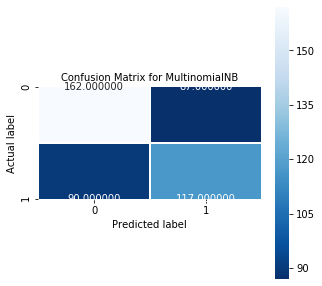

In [18]:
mnb_cm = metrics.confusion_matrix(real_test_data['test_label'],mnb_pred)
plt.show()
plt.figure(figsize=(5,5))
sns.heatmap(mnb_cm, annot=True, linewidth=.5, square = True, cmap = 'Blues_r',fmt='f');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix for MultinomialNB', size = 10);

report = classification_report(real_test_data['test_label'],mnb_pred)
print(report)

In [19]:
pa_tfidf_clf = PassiveAggressiveClassifier(50)
pa_tfidf_clf.fit(count_train, real_train_data['train_label'])
pac_pred = pa_tfidf_clf.predict(count_test)
pac_score = metrics.accuracy_score(real_test_data['test_label'], pac_pred)
pac_cm = metrics.confusion_matrix(real_test_data['test_label'], pac_pred, labels=['true', 'false'])
print('Confusion Matrix --- PassiveAggressiveClassifier')
print(pac_cm)

print("Passive Aggressive Classifier accuracy:   %0.3f" % pac_score)

Confusion Matrix --- PassiveAggressiveClassifier
[[103 104]
 [ 97 152]]
Passive Aggressive Classifier accuracy:   0.559


              precision    recall  f1-score   support

       false       0.59      0.61      0.60       249
        true       0.52      0.50      0.51       207

    accuracy                           0.56       456
   macro avg       0.55      0.55      0.55       456
weighted avg       0.56      0.56      0.56       456



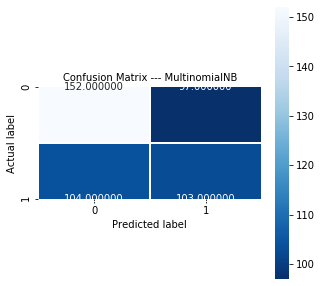

In [31]:
pac_cm = metrics.confusion_matrix(real_test_data['test_label'],pac_pred)
plt.show()
plt.figure(figsize=(5,5))
sns.heatmap(pac_cm, annot=True, linewidth=.5, square = True, cmap = 'Blues_r',fmt='f');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix --- MultinomialNB', size = 10);

report = classification_report(real_test_data['test_label'],pac_pred)
print(report)

In [21]:
svc_tfidf_clf = LinearSVC()
svc_tfidf_clf.fit(count_train, real_train_data['train_label'])
svc_pred = svc_tfidf_clf.predict(count_test)
svc_score = metrics.accuracy_score(real_test_data['test_label'], svc_pred)
svc_cm = metrics.confusion_matrix(real_test_data['test_label'], svc_pred, labels=['true', 'false'])
print('Confusion Matrix --- LinearSVC')
print(svc_cm)

print("Support Vector Classifier accuracy:   %0.3f" % svc_score)

Confusion Matrix --- LinearSVC
[[102 105]
 [100 149]]
Support Vector Classifier accuracy:   0.550


              precision    recall  f1-score   support

       false       0.59      0.60      0.59       249
        true       0.50      0.49      0.50       207

    accuracy                           0.55       456
   macro avg       0.55      0.55      0.55       456
weighted avg       0.55      0.55      0.55       456



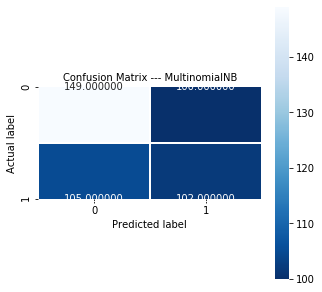

In [25]:
svc_cm = metrics.confusion_matrix(real_test_data['test_label'],svc_pred)
plt.show()
plt.figure(figsize=(5,5))
sns.heatmap(svc_cm, annot=True, linewidth=.5, square = True, cmap = 'Blues_r',fmt='f');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix --- MultinomialNB', size = 10);

report = classification_report(real_test_data['test_label'],svc_pred)
print(report)

In [26]:
sgd_tfidf_clf = SGDClassifier()
sgd_tfidf_clf.fit(count_train, real_train_data['train_label'])
sgd_pred = sgd_tfidf_clf.predict(count_test)
sgd_score = metrics.accuracy_score(real_test_data['test_label'], sgd_pred)
sgd_cm = metrics.confusion_matrix(real_test_data['test_label'], sgd_pred, labels=['true', 'false'])
print('Confusion Matrix --- SGD Classifier')
print(sgd_cm)

print("Stochastic Gradient Descent Classifier accuracy:   %0.3f" % sgd_score)

Confusion Matrix --- SGD Classifier
[[101 106]
 [100 149]]
Stochastic Gradient Descent Classifier accuracy:   0.548


              precision    recall  f1-score   support

       false       0.58      0.60      0.59       249
        true       0.50      0.49      0.50       207

    accuracy                           0.55       456
   macro avg       0.54      0.54      0.54       456
weighted avg       0.55      0.55      0.55       456



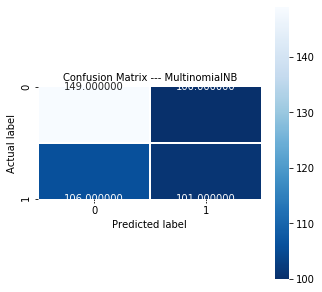

In [27]:
cm = metrics.confusion_matrix(real_test_data['test_label'],sgd_pred)
plt.show()
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidth=.5, square = True, cmap = 'Blues_r',fmt='f');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix --- MultinomialNB', size = 10);

report = classification_report(real_test_data['test_label'],sgd_pred)
print(report)